In [1]:
# Cell 1 — Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect("../inventory.db")

# Load clean data (same filters as before)
raw = pd.read_sql("SELECT * FROM vendor_sales_summary", conn)
df  = raw[
    (raw['TotalSalesQty']  > 0) &
    (raw['GrossProfit']    > 0) &
    (raw['ProfitMargin']   > 0) &
    (raw['ProfitMargin']   < 100)
].copy()

sns.set_theme(style='whitegrid')

# ── Helper function — define it here so ALL cells in this notebook can use it
def fmt_dollars(v):
    """Convert a number to readable dollar format. e.g. 1500000 → '$1.5M'"""
    if v >= 1_000_000: return f'${v/1_000_000:.1f}M'
    if v >= 1_000:     return f'${v/1_000:.1f}K'
    return f'${v:.0f}'

print(f"Clean data loaded: {len(df):,} rows ✅")
print(f"fmt_dollars test: {fmt_dollars(1_500_000)}")   # should print $1.5M




Clean data loaded: 15 rows ✅
fmt_dollars test: $1.5M


In [2]:
# Cell 2 — What is a Confidence Interval? (Theory first, then code)
#
# Imagine you want to know the TRUE average profit margin of ALL vendors.
# You can't survey every transaction perfectly, so you use your sample.
#
# A 95% Confidence Interval means:
# "We are 95% confident the TRUE average margin falls between X% and Y%"
#
# HOW IT'S CALCULATED:
# 1. Calculate sample mean
# 2. Calculate standard error (how much means vary across samples)
# 3. Find t-critical value (accounts for sample size uncertainty)
# 4. CI = mean ± (t_critical × standard_error)
#
# Wider CI = less certainty (small sample or high variance)
# Narrower CI = more certainty (large sample or low variance)

def confidence_interval(data, confidence=0.95):
    """
    Calculate confidence interval for a sample of data.
    
    Parameters:
        data       : array-like of values
        confidence : confidence level (default 95%)
    
    Returns:
        mean, lower_bound, upper_bound
    """
    n          = len(data)                        # sample size
    mean       = data.mean()                      # sample mean
    se         = stats.sem(data)                  # standard error
    # t.ppf gives the t-critical value for our confidence level and sample size
    t_critical = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin     = t_critical * se                  # margin of error

    lower = mean - margin
    upper = mean + margin
    return mean, lower, upper

# Test on overall profit margin
mean, lower, upper = confidence_interval(df['ProfitMargin'].dropna())
print(f"Overall Profit Margin:")
print(f"  Mean  : {mean:.2f}%")
print(f"  95% CI: [{lower:.2f}%, {upper:.2f}%]")
print(f"\nInterpretation: We are 95% confident the true average profit")
print(f"margin lies between {lower:.2f}% and {upper:.2f}%")

Overall Profit Margin:
  Mean  : 55.11%
  95% CI: [53.41%, 56.80%]

Interpretation: We are 95% confident the true average profit
margin lies between 53.41% and 56.80%


In [3]:
# Cell 3 — Segment vendors into Top vs Low performers
# We use sales volume to define "top" and "low"
# This is a business decision — we're asking:
# "Do high-revenue vendors have different margins than low-revenue vendors?"

q75 = df['TotalSalesDollars'].quantile(0.75)
q25 = df['TotalSalesDollars'].quantile(0.25)

# Top performers: sales above 75th percentile
top_vendors = df[df['TotalSalesDollars'] >= q75]
# Low performers: sales below 25th percentile
low_vendors = df[df['TotalSalesDollars'] <= q25]

print(f"Top vendor records: {len(top_vendors):,}  (sales >= {fmt_dollars(q75)})")
print(f"Low vendor records: {len(low_vendors):,}  (sales <= {fmt_dollars(q25)})")

# Extract profit margins for each group
top_margins = top_vendors['ProfitMargin'].dropna()
low_margins = low_vendors['ProfitMargin'].dropna()

# Calculate CIs for each group
top_mean, top_lo, top_hi = confidence_interval(top_margins)
low_mean, low_lo, low_hi = confidence_interval(low_margins)

print(f"\nTop Vendors — Margin CI: [{top_lo:.2f}%, {top_hi:.2f}%]  mean={top_mean:.2f}%")
print(f"Low Vendors — Margin CI: [{low_lo:.2f}%, {low_hi:.2f}%]  mean={low_mean:.2f}%")

# Non-overlapping CIs → groups are likely significantly different
if top_hi < low_lo or low_hi < top_lo:
    print("\n⚠️ CIs do not overlap → groups are likely significantly different")
else:
    print("\nCIs overlap → run hypothesis test to confirm difference")

Top vendor records: 4  (sales >= $2473.2M)
Low vendor records: 4  (sales <= $711.4M)

Top Vendors — Margin CI: [50.81%, 55.23%]  mean=53.02%
Low Vendors — Margin CI: [56.41%, 58.66%]  mean=57.53%

⚠️ CIs do not overlap → groups are likely significantly different


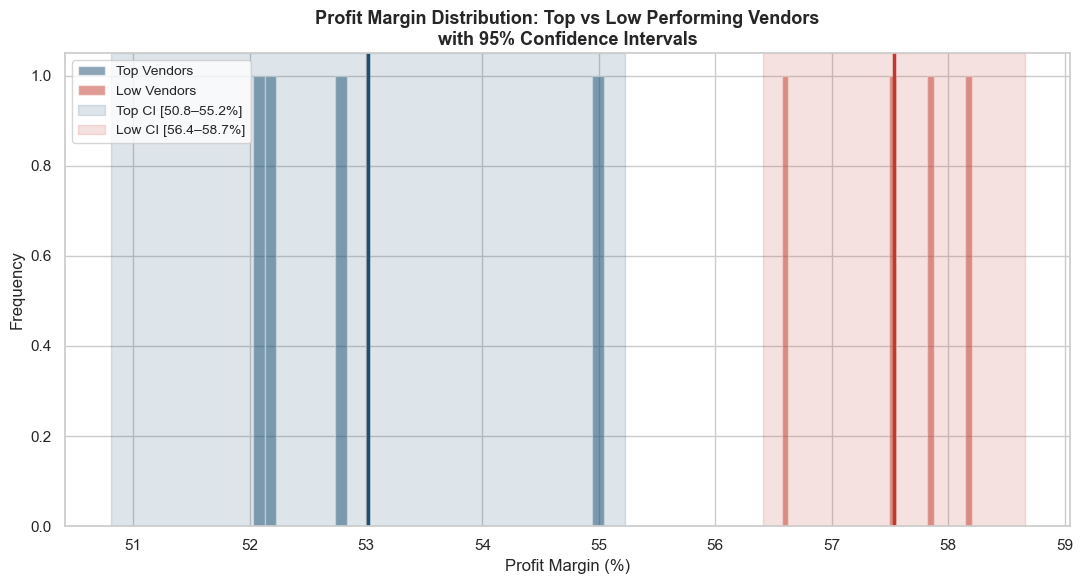

In [4]:
# Cell 4 — Visualize the Confidence Intervals
# Plotting distributions with CI lines makes the difference visible

fig, ax = plt.subplots(figsize=(11, 6))

# Plot distributions (histograms)
ax.hist(top_margins, bins=30, alpha=0.5, color='#1B4F72', label='Top Vendors')
ax.hist(low_margins, bins=30, alpha=0.5, color='#C0392B', label='Low Vendors')

# Draw mean lines
ax.axvline(top_mean, color='#1B4F72', lw=2.5, ls='-')
ax.axvline(low_mean, color='#C0392B', lw=2.5, ls='-')

# Shade CI regions
ax.axvspan(top_lo, top_hi, alpha=0.15, color='#1B4F72',
           label=f'Top CI [{top_lo:.1f}–{top_hi:.1f}%]')
ax.axvspan(low_lo, low_hi, alpha=0.15, color='#C0392B',
           label=f'Low CI [{low_lo:.1f}–{low_hi:.1f}%]')

ax.set_xlabel('Profit Margin (%)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Profit Margin Distribution: Top vs Low Performing Vendors\nwith 95% Confidence Intervals',
             fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/09_confidence_intervals.png', bbox_inches='tight')
plt.show()

In [5]:
# Cell 5 — Hypothesis Testing
#
# WHAT IS A HYPOTHESIS TEST?
# It answers: "Is the difference I see REAL, or just random chance?"
#
# We set up two competing hypotheses:
# H0 (Null):        There is NO significant difference in margins between top and low vendors
# H1 (Alternative): There IS a significant difference in margins
#
# HOW IT WORKS:
# The t-test calculates a p-value = probability of seeing this difference by random chance
# If p-value < 0.05 (our threshold, called alpha):
#   → difference is statistically significant → REJECT H0
# If p-value >= 0.05:
#   → difference could be random chance → FAIL TO REJECT H0
#
# Think of it like a court case:
# H0 = "innocent until proven guilty"
# p < 0.05 = enough evidence to convict (reject H0)

print("="*55)
print("HYPOTHESIS TEST: Top vs Low Vendor Profit Margins")
print("="*55)
print(f"\nH0: mean margin of top vendors = mean margin of low vendors")
print(f"H1: mean margin of top vendors ≠ mean margin of low vendors")
print(f"\nSignificance level (alpha): 0.05")

# stats.ttest_ind = independent two-sample t-test
# Use this when comparing two DIFFERENT groups (not the same group twice)
t_stat, p_value = stats.ttest_ind(top_margins, low_margins)

print(f"\n--- RESULTS ---")
print(f"t-statistic : {t_stat:.4f}")
print(f"p-value     : {p_value:.6f}")
print(f"\n--- CONCLUSION ---")

if p_value < 0.05:
    print(f"p-value ({p_value:.4f}) < 0.05  →  REJECT H0 ✅")
    print(f"There IS a statistically significant difference in profit margins.")
    print(f"Top vendors avg: {top_mean:.2f}%  |  Low vendors avg: {low_mean:.2f}%")
    if low_mean > top_mean:
        print(f"\n💡 Insight: Low-volume vendors have HIGHER margins ({low_mean:.1f}% vs {top_mean:.1f}%)")
        print(f"   This suggests they sell premium products with less volume pressure.")
else:
    print(f"p-value ({p_value:.4f}) >= 0.05  →  FAIL TO REJECT H0")
    print(f"No statistically significant difference found.")

HYPOTHESIS TEST: Top vs Low Vendor Profit Margins

H0: mean margin of top vendors = mean margin of low vendors
H1: mean margin of top vendors ≠ mean margin of low vendors

Significance level (alpha): 0.05

--- RESULTS ---
t-statistic : -5.7985
p-value     : 0.001153

--- CONCLUSION ---
p-value (0.0012) < 0.05  →  REJECT H0 ✅
There IS a statistically significant difference in profit margins.
Top vendors avg: 53.02%  |  Low vendors avg: 57.53%

💡 Insight: Low-volume vendors have HIGHER margins (57.5% vs 53.0%)
   This suggests they sell premium products with less volume pressure.


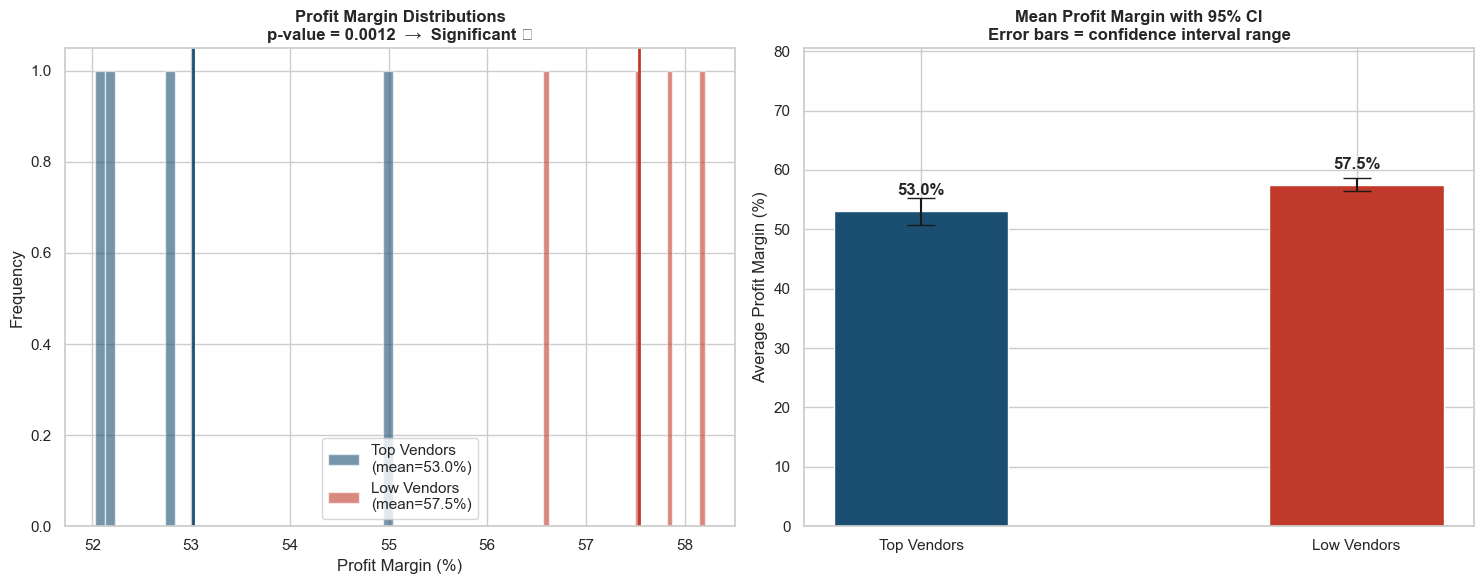

All statistics charts saved ✅


In [6]:
# Cell 6 — Final Summary Chart for the Statistics Section
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Left: Distribution comparison ---
ax1.hist(top_margins, bins=30, alpha=0.6, color='#1B4F72', label=f'Top Vendors\n(mean={top_mean:.1f}%)')
ax1.hist(low_margins, bins=30, alpha=0.6, color='#C0392B', label=f'Low Vendors\n(mean={low_mean:.1f}%)')
ax1.axvline(top_mean, color='#1B4F72', lw=2)
ax1.axvline(low_mean, color='#C0392B', lw=2)
ax1.set_title(f'Profit Margin Distributions\np-value = {p_value:.4f}  →  {"Significant ✅" if p_value < 0.05 else "Not Significant"}',
              fontweight='bold')
ax1.set_xlabel('Profit Margin (%)')
ax1.set_ylabel('Frequency')
ax1.legend()

# --- Right: CI comparison bar chart ---
groups = ['Top Vendors', 'Low Vendors']
means  = [top_mean, low_mean]
errors = [top_mean - top_lo, low_mean - low_lo]  # margin of error

bars = ax2.bar(groups, means, color=['#1B4F72','#C0392B'],
               yerr=errors,            # error bars show CI
               capsize=10,             # caps on error bars
               edgecolor='white', width=0.4)
ax2.set_ylabel('Average Profit Margin (%)')
ax2.set_title('Mean Profit Margin with 95% CI\nError bars = confidence interval range',
              fontweight='bold')
ax2.set_ylim(0, max(means) * 1.4)

for bar, val in zip(bars, means):
    ax2.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + max(errors) + 0.5,
             f'{val:.1f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../outputs/10_hypothesis_test.png', bbox_inches='tight')
plt.show()
print("All statistics charts saved ✅")